In [4]:
# @title Mount Drive and install and import libraries
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [11]:
!pip install datasets
!pip install peft
!pip install evaluate
!pip install wandb

In [12]:
import torch
from huggingface_hub import login
from datasets import load_dataset, DatasetDict, Dataset
from transformers import (AutoTokenizer,
                          AutoConfig,
                          AutoModelForSequenceClassification,
                          DataCollatorWithPadding,
                          TrainingArguments,
                          Trainer)
from peft import PeftModel, PeftConfig, get_peft_model, LoraConfig
import evaluate
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorboard
import wandb

In [13]:
wandb.login()

wandb: Currently logged in as: karthika-ncsu (karthika-ncsu-intelliswift-software). Use `wandb login --relogin` to force relogin


True

In [14]:
# @title load and visualise dataset
dataset =load_dataset("karthika-ml/my_truncated_imdb")
dataset

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['label', 'text'],
        num_rows: 1000
    })
    validation: Dataset({
        features: ['label', 'text'],
        num_rows: 1000
    })
})

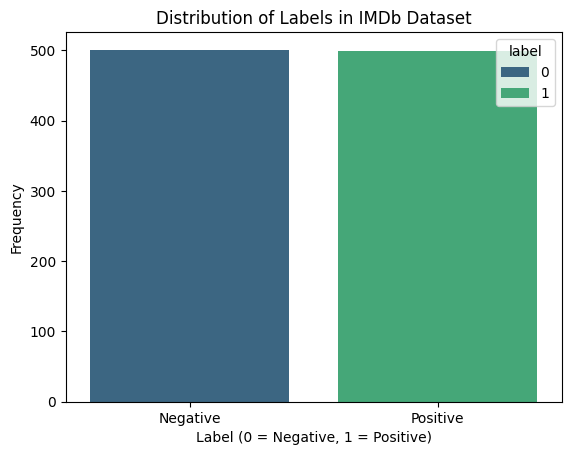

In [15]:
#Let us visualise data balance
# Count the occurrences of each label in the train set
label_counts = dataset['train'].features['label']
label_distribution = dataset['train'].to_pandas()['label'].value_counts()

# Plot the distribution of labels
sns.barplot(x=label_distribution.index, y=label_distribution.values, palette="viridis", hue=label_distribution.index, legend = "auto")
plt.title("Distribution of Labels in IMDb Dataset")
plt.xlabel("Label (0 = Negative, 1 = Positive)")
plt.ylabel("Frequency")
plt.xticks([0, 1], ['Negative', 'Positive'])

plt.show()

In [17]:
# @title Model
model_checkpoint = 'distilbert-base-uncased'

#define label maps
id2label = {0: "Negative", 1: "Positive"}
label2id = {"Negative":0, "Positive":1}

#generate classification model from model
model = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint, num_labels=2, id2label=id2label, label2id=label2id)

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [19]:
# @title Data preprocess
# create tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, add_prefix_space=True)

# add pad token if none exists
if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({'pad_token': '[PAD]'})
    model.resize_token_embeddings(len(tokenizer))

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [20]:
# create tokenize function
def tokenize_function(examples):
    # extract text
    text = examples["text"]

    #tokenize and truncate text
    tokenizer.truncation_side = "left"
    tokenized_inputs = tokenizer(
        text,
        return_tensors="np",
        truncation=True,
        max_length=512
    )

    return tokenized_inputs

In [21]:
# tokenize training and validation datasets
tokenized_dataset = dataset.map(tokenize_function, batched=True)
tokenized_dataset

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['label', 'text', 'input_ids', 'attention_mask'],
        num_rows: 1000
    })
    validation: Dataset({
        features: ['label', 'text', 'input_ids', 'attention_mask'],
        num_rows: 1000
    })
})

In [22]:
#create a data collator
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [23]:
# display model architecture
model

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [24]:
# @title Evaluate model

# import accuracy evaluation metric
accuracy = evaluate.load("accuracy")

In [25]:
# define an evaluation function to pass into trainer later
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=1)

    return {"accuracy": accuracy.compute(predictions=predictions, references=labels)}

In [26]:
# @title Input text to vanilla model
# define list of examples
text_list = ["It was good.", "Not a fan, don't recommed.", "Better than the first one.", "This is not worth watching even once.", "This one is a pass."]

print("Untrained model predictions:")
print("----------------------------")
for text in text_list:
    # tokenize text
    inputs = tokenizer.encode(text, return_tensors="pt")
    # compute logits
    logits = model(inputs).logits
    # convert logits to label
    predictions = torch.argmax(logits)

    print(text + " - " + id2label[predictions.tolist()])

Untrained model predictions:
----------------------------
It was good. - Positive
Not a fan, don't recommed. - Positive
Better than the first one. - Positive
This is not worth watching even once. - Positive
This one is a pass. - Positive


In [27]:
# @title Train model using LoRA
peft_config = LoraConfig(task_type="SEQ_CLS",
                        r=4,
                        lora_alpha=32,
                        lora_dropout=0.01,
                        target_modules = ['q_lin'])

In [28]:
peft_config

LoraConfig(peft_type=<PeftType.LORA: 'LORA'>, auto_mapping=None, base_model_name_or_path=None, revision=None, task_type='SEQ_CLS', inference_mode=False, r=4, target_modules={'q_lin'}, lora_alpha=32, lora_dropout=0.01, fan_in_fan_out=False, bias='none', use_rslora=False, modules_to_save=None, init_lora_weights=True, layers_to_transform=None, layers_pattern=None, rank_pattern={}, alpha_pattern={}, megatron_config=None, megatron_core='megatron.core', loftq_config={}, use_dora=False, layer_replication=None, runtime_config=LoraRuntimeConfig(ephemeral_gpu_offload=False))

In [29]:
model = get_peft_model(model, peft_config)
model.print_trainable_parameters()


trainable params: 628,994 || all params: 67,584,004 || trainable%: 0.9307


In [30]:
# hyperparameters
lr = 1e-3
batch_size = 4
num_epochs = 10

In [33]:
# define training arguments
training_args = TrainingArguments(
    output_dir= model_checkpoint + "-lora-text-classification",
    learning_rate=lr,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_epochs,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    report_to="wandb",
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [34]:
# creater trainer object
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator, # this will dynamically pad examples in each batch to be equal length
    compute_metrics=compute_metrics,
)

# train model
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.784262,{'accuracy': 0.796}
2,0.424400,0.563078,{'accuracy': 0.842}
3,0.424400,0.769167,{'accuracy': 0.854}
4,0.192900,0.847147,{'accuracy': 0.849}
5,0.192900,0.876970,{'accuracy': 0.855}
6,0.064600,1.057181,{'accuracy': 0.85}
7,0.064600,1.078658,{'accuracy': 0.859}
8,0.017500,1.138575,{'accuracy': 0.863}
9,0.017500,1.189878,{'accuracy': 0.865}
10,0.004200,1.203241,{'accuracy': 0.865}


TrainOutput(global_step=2500, training_loss=0.14070030450820922, metrics={'train_runtime': 526.2458, 'train_samples_per_second': 19.003, 'train_steps_per_second': 4.751, 'total_flos': 1146602419523040.0, 'train_loss': 0.14070030450820922, 'epoch': 10.0})